In [424]:
import numpy as np
import pandas as pd

df = pd.read_csv("../data/total_data.csv")

In [425]:
df.drop(columns=['Unnamed: 0'], inplace=True)

In [426]:
df.rename(columns={"full_date": "date_time",
                  "pm": "value"}, inplace=True)

In [427]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [428]:
test_date = "2020-03-01"
df_train = df[df['date_time'] < test_date].copy()
df_test = df[df['date_time'] >= test_date].copy()

In [431]:
aust = df_train['value'].copy()

In [432]:
import numpy as np
import pandas as pd
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt


def holt_winters_imputation_and_expand(
    time_series,
    seasonal_periods,
    interim_fill_method='linear',
    left_expand=0,
    right_expand=0
):
    """
    Impute missing values and optionally expand the series using multiple Holt-Winters models.

    Parameters:
    - time_series: pd.Series
        The time series data with NaN values to be imputed.
    - seasonal_periods: int
        The number of observations per cycle of seasonality.
    - interim_fill_method: str, optional
        Method to temporarily fill missing values.
    - left_expand: int, optional
        Number of periods to expand backward in time.
    - right_expand: int, optional
        Number of periods to expand forward in time.

    Returns:
    - expanded_series: pd.Series
        The series with imputed values and optionally expanded data.
    """
    # Check if the input is a pandas Series
    if not isinstance(time_series, pd.Series):
        raise ValueError("Input time_series must be a pandas Series.")

    # Step 1: Temporarily fill missing values
    interim_filled = time_series.interpolate(method=interim_fill_method)

    # Step 2: Fit 4 Holt-Winters models with different configurations
    models = []
    models.append(ExponentialSmoothing(
        interim_filled,
        seasonal_periods=seasonal_periods,
        trend="add",
        seasonal="add",
        use_boxcox=True,
        initialization_method="estimated"
    ).fit())
    models.append(ExponentialSmoothing(
        interim_filled,
        seasonal_periods=seasonal_periods,
        trend="add",
        seasonal="mul",
        use_boxcox=True,
        initialization_method="estimated"
    ).fit())
    models.append(ExponentialSmoothing(
        interim_filled,
        seasonal_periods=seasonal_periods,
        trend="add",
        seasonal="add",
        damped_trend=True,
        use_boxcox=True,
        initialization_method="estimated"
    ).fit())
    models.append(ExponentialSmoothing(
        interim_filled,
        seasonal_periods=seasonal_periods,
        trend="add",
        seasonal="mul",
        damped_trend=True,
        use_boxcox=True,
        initialization_method="estimated"
    ).fit())

    # Step 3: Calculate mean predictions across all models
    fitted_values = np.mean([model.fittedvalues for model in models], axis=0)

    # Step 4: Impute missing values
    imputed_series = time_series.copy()
    imputed_series[time_series.isna()] = fitted_values[time_series.isna()]

    # Step 5: Expand the series if needed
    if left_expand > 0 or right_expand > 0:
        # Forecast future values
        forecasts = np.mean([model.forecast(steps=right_expand) for model in models], axis=0) if right_expand > 0 else []
        # Backcast past values
        backcasts = np.mean([model.predict(start=-left_expand, end=-1) for model in models], axis=0) if left_expand > 0 else []

        # Create indices for backcasts and forecasts
        backcast_index = range(imputed_series.index[0] - left_expand, imputed_series.index[0]) if left_expand > 0 else []
        forecast_index = range(imputed_series.index[-1] + 1, imputed_series.index[-1] + right_expand + 1) if right_expand > 0 else []

        # Convert backcasts and forecasts to series
        backcast_series = pd.Series(backcasts, index=backcast_index) if left_expand > 0 else pd.Series()
        forecast_series = pd.Series(forecasts, index=forecast_index) if right_expand > 0 else pd.Series()

        # Concatenate the series
        expanded_series = pd.concat([backcast_series, imputed_series, forecast_series])
    else:
        expanded_series = imputed_series

    return expanded_series


def plot_imputation_results(original_series, imputed_series, title="Holt-Winters Imputation Results"):
    """
    Plot the original time series with missing values and the imputed time series.

    Parameters:
    - original_series: pd.Series
        The original time series with NaN values.
    - imputed_series: pd.Series
        The time series after imputation.
    - title: str
        Title for the plot.
    """
    plt.figure(figsize=(12, 6))
    
    # Plot the imputed series
    plt.plot(imputed_series.index, imputed_series, label="Imputed & Expanded Series", 
             linestyle="-", marker="o", color="green")
    
    # Plot the original series
    plt.plot(original_series.index, original_series, label="Original Series (Observed)", 
             linestyle="--", marker="o", alpha=0.7, color="blue")
    
    # Highlight missing values
    missing_indices = original_series[original_series.isna()].index
    plt.scatter(missing_indices, imputed_series[missing_indices], color="red", 
                label="Imputed Points", zorder=5)

    # Customization
    plt.title(title, fontsize=16)
    plt.xlabel("Time", fontsize=14)
    plt.ylabel("Value", fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()





In [382]:
# Example Usage
data = aust.values.copy()
data[50:70] = np.nan
data[150:180] = np.nan
data[300:330] = np.nan
time_series = pd.Series(data)

expanded_series = holt_winters_imputation_and_expand(
    time_series,
    seasonal_periods=365,
    left_expand=50,
    right_expand=50
)

plot_imputation_results(time_series, expanded_series)

KeyboardInterrupt: 

In [82]:
df_clusters = pd.read_csv("../data/clusters0_df.csv")

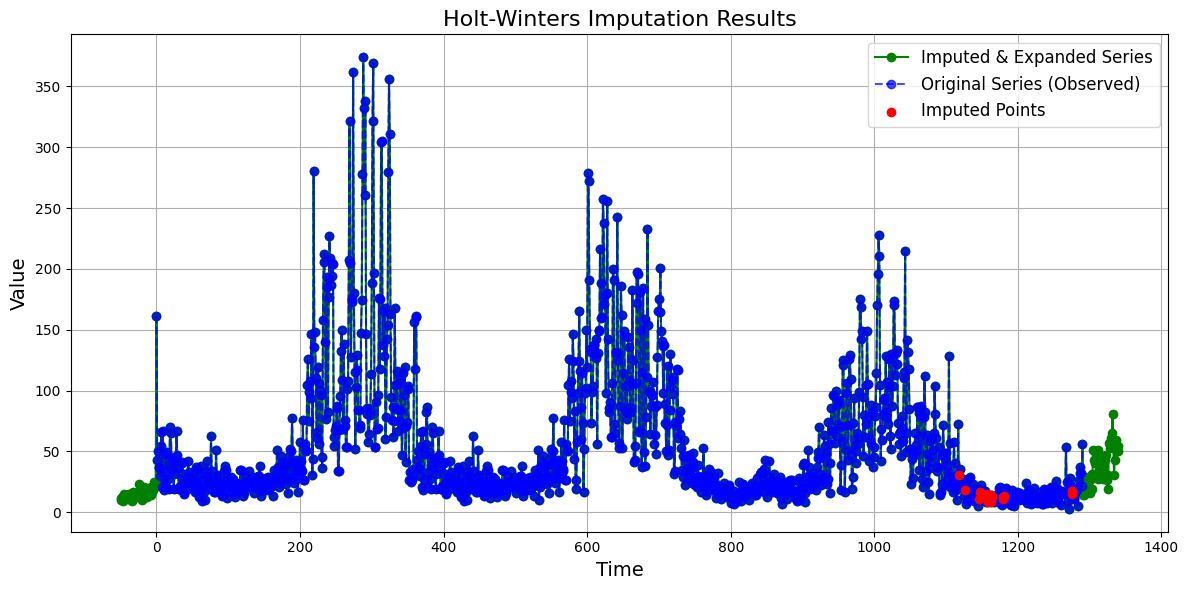

c:\Users\77019\pyver\py312\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\77019\pyver\py312\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


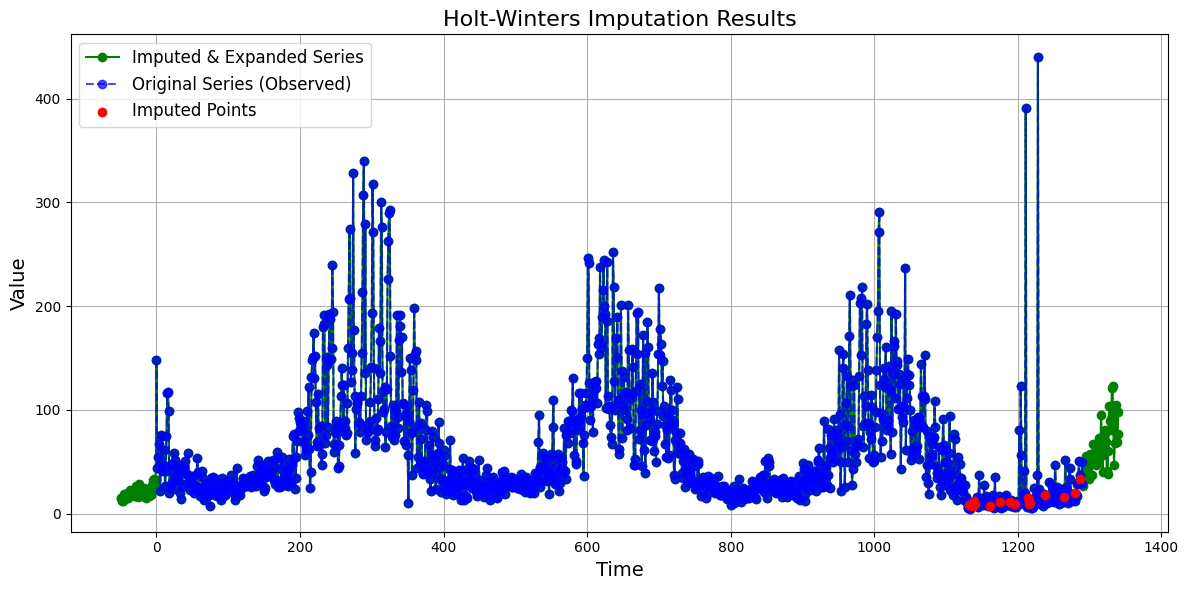

c:\Users\77019\pyver\py312\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\77019\pyver\py312\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


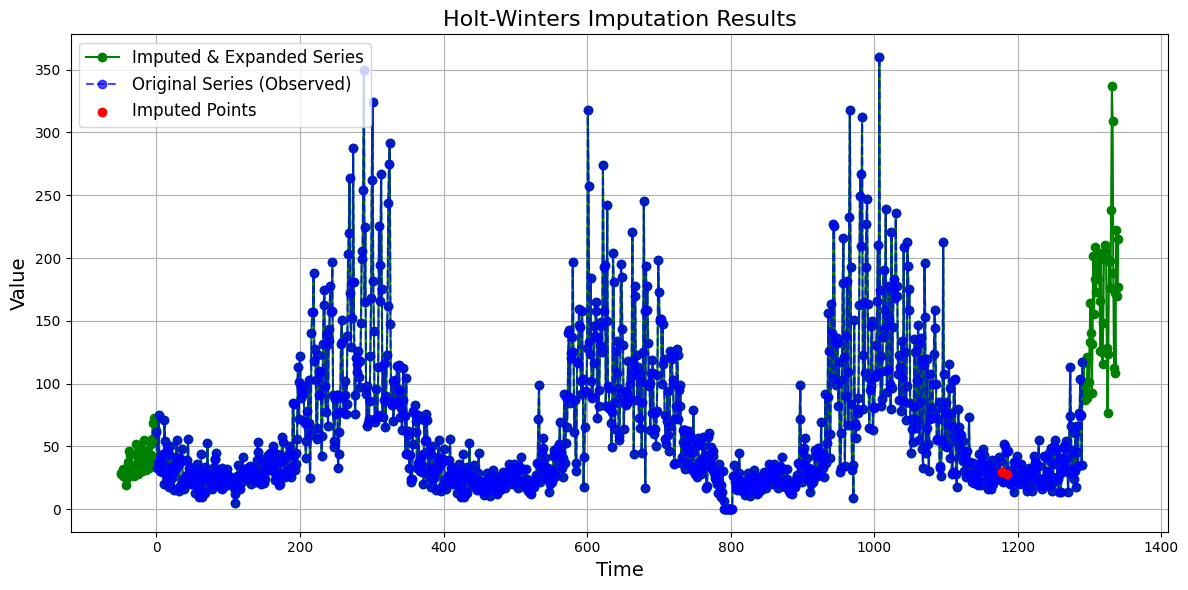

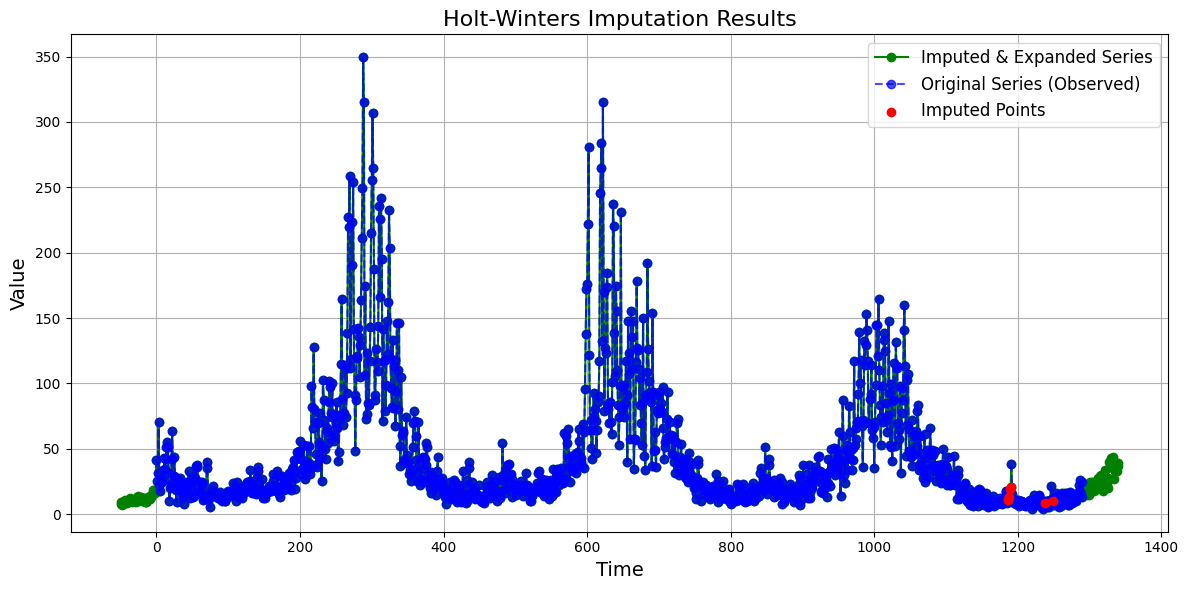

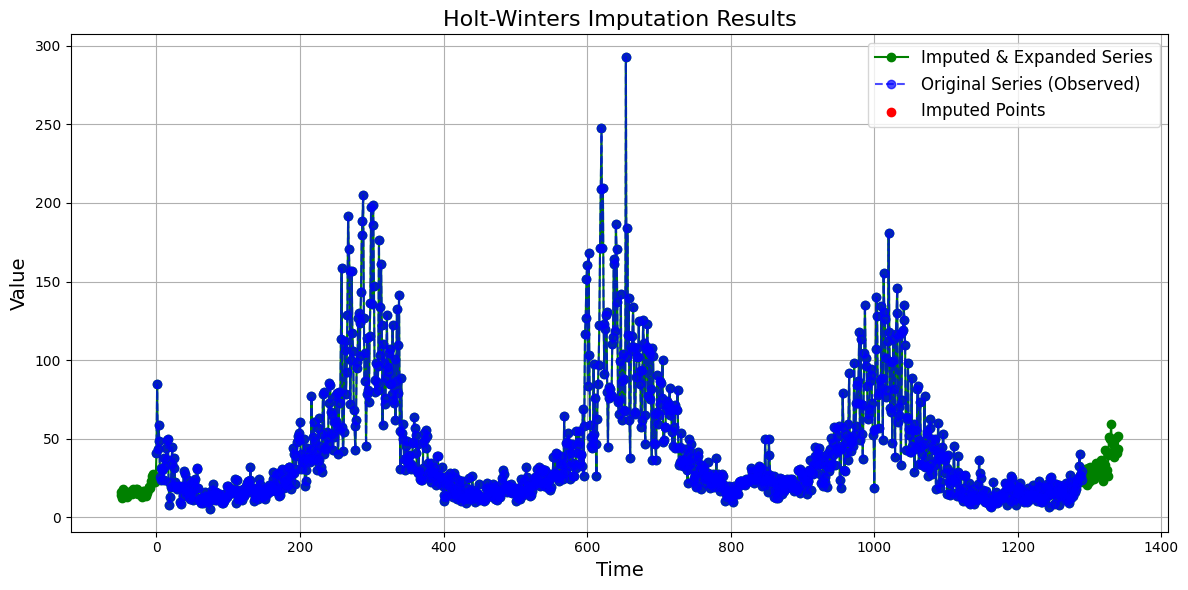

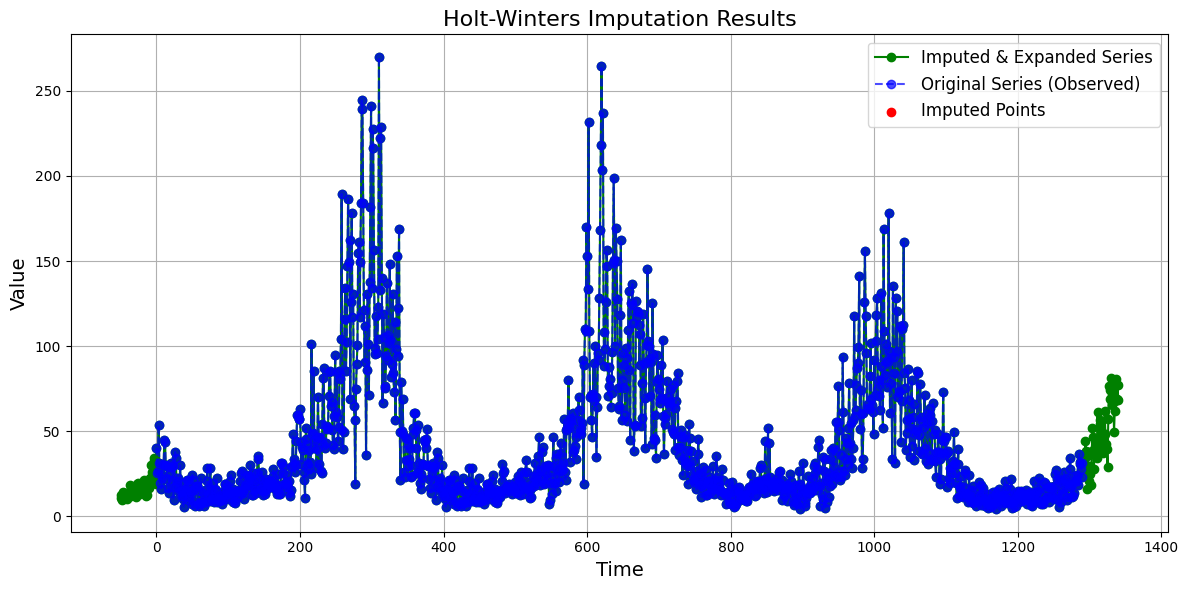

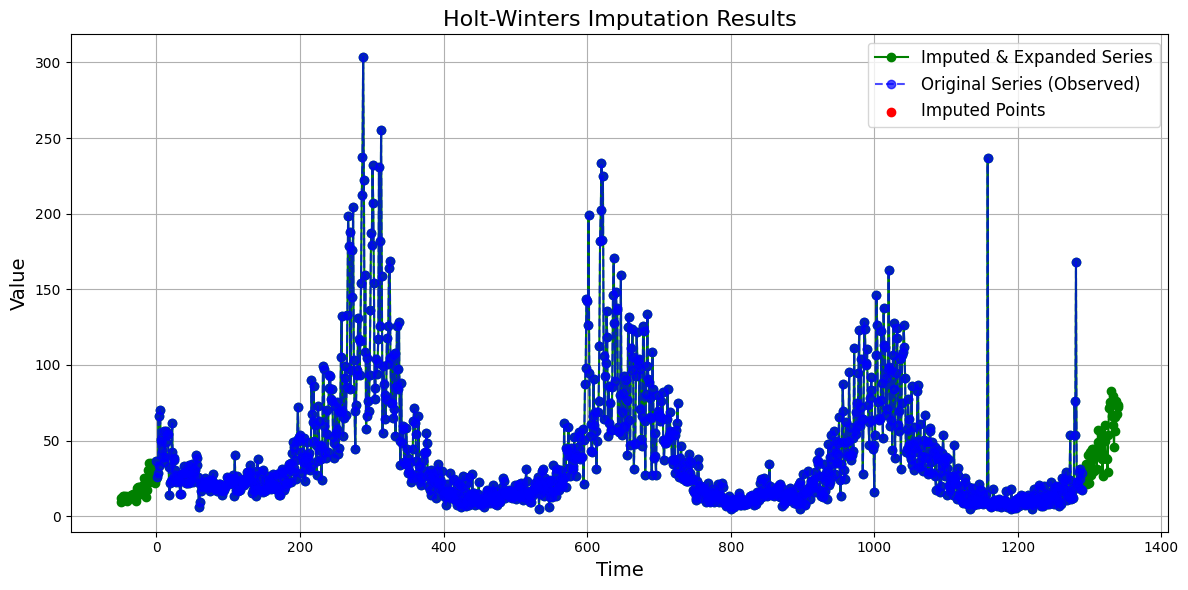

c:\Users\77019\pyver\py312\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\77019\pyver\py312\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


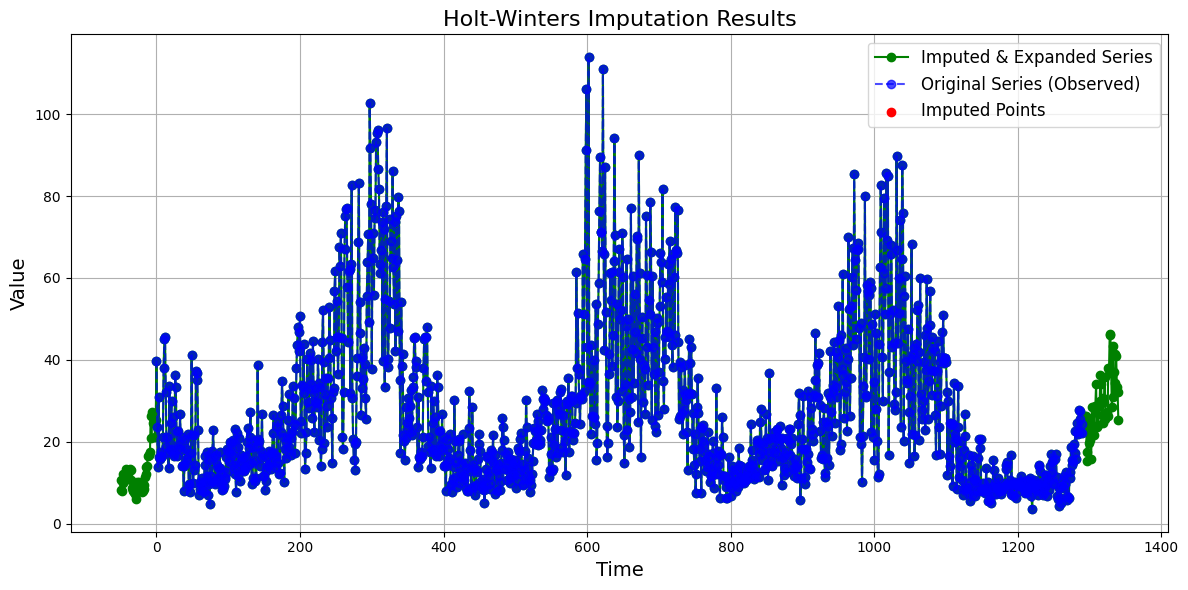

In [21]:
for i in range(8):
    time_series = df_clusters[str(i)].copy()
    expanded_series = holt_winters_imputation_and_expand(
        time_series,
        seasonal_periods=365,
        left_expand=50,
        right_expand=50
    )

    plot_imputation_results(time_series, expanded_series)

## AR again?

In [433]:
import sktime
from matplotlib import pyplot
import matplotlib as plt
import seaborn
import datetime
import pandas as pd
import statsmodels
import numpy as np

In [434]:
df.set_index("date_time", inplace=True)

df.index = pd.to_datetime(df.index)

# Generate the complete range of dates
full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')

# Reindex the DataFrame to include all dates
df = df.reindex(full_range)

# Set the index name back (optional)
df.index.name = 'date_time'

In [435]:
df['value'] = holt_winters_imputation_and_expand(
    df['value'],
    seasonal_periods=365,
)

In [436]:
sm_data = df.copy()
# sm_data.set_index("date_time", inplace=True)

In [437]:
from statsmodels.tsa.stattools import adfuller
adf_result = adfuller(sm_data)
print(adf_result[1])

0.4200543317771528


In [438]:
from statsmodels.tsa.stattools import kpss
kpss_result = kpss(sm_data)
print(kpss_result[1])

0.1


C:\Users\77019\AppData\Local\Temp\ipykernel_23400\2099004755.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(sm_data)


In [439]:
sm_data.index = pd.date_range(start=sm_data.index[0], periods=len(sm_data.index), freq="D")

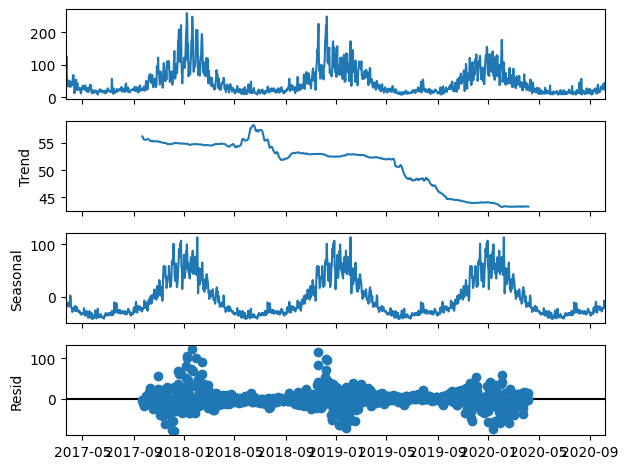

In [440]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(sm_data, model='additive', period=368)
result.plot()
pyplot.show()

In [441]:
# from sktime.transformations.series.difference import Differencer
# transformer = Differencer(lags=1)
# sm_data = transformer.fit_transform(sm_data)

In [442]:
# # Seasonal differencing
# seasonal_period = 368  # Replace with your data's observed seasonal period
# sm_data = sm_data.diff(periods=seasonal_period).dropna()

In [443]:
from scipy import stats
# Box-Cox transformation (ensure series is positive)
boxcox_transformed_series, lambda_value = stats.boxcox(sm_data['value'].dropna() + 1)  # Add 1 to handle zero or negative values
sm_data['value'] = boxcox_transformed_series

In [444]:
from sktime.split import temporal_train_test_split
train, test = temporal_train_test_split(sm_data, test_size=df_test.shape[0])

In [445]:
sm_data

,value
2017-03-22,2.385457
2017-03-23,2.366080
2017-03-24,2.454567
2017-03-25,2.293832
2017-03-26,2.156623
...,...
2020-10-03,2.180312
2020-10-04,2.101230
2020-10-05,2.085614
2020-10-06,2.008837


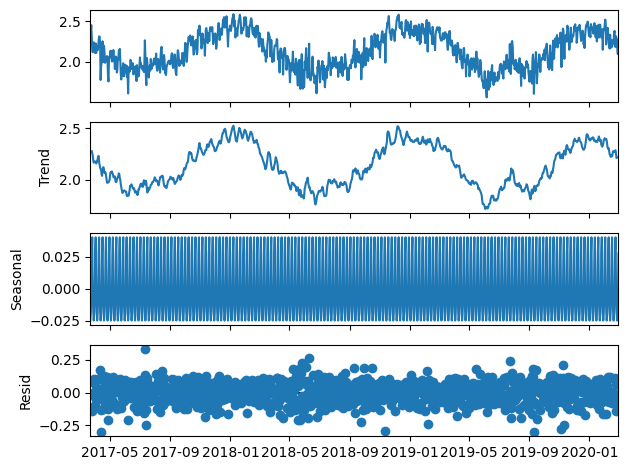

In [446]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(train, model='additive')
result.plot()
pyplot.show()

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

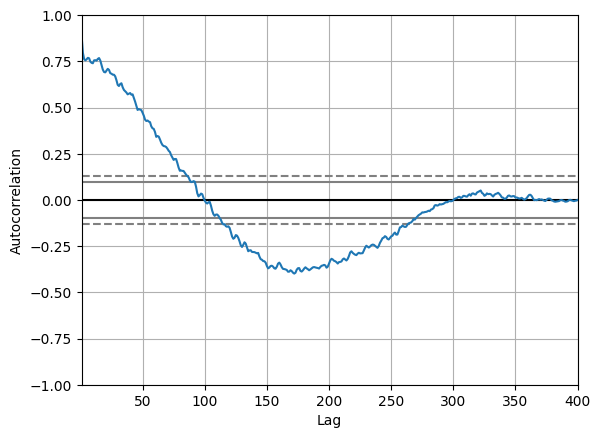

In [447]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(train[:400])

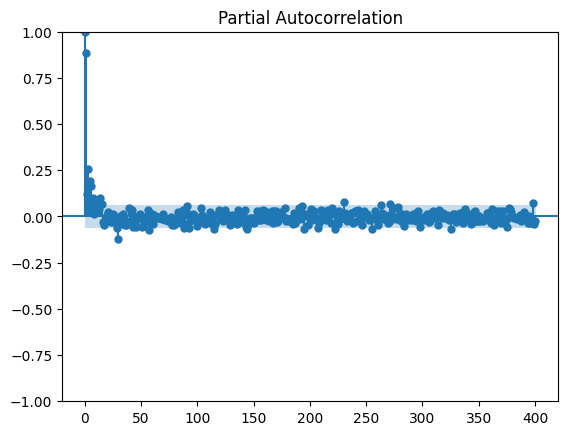

In [448]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(train, lags=400)
pyplot.show()

there are several significant correlations, so it might be worth it to try periodicity based forecasting model.

In [449]:
from statsmodels.tsa.ar_model import AutoReg
params = AutoReg(train, lags = 305)
res = params.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                  value   No. Observations:                 1075
Model:                   AutoReg(305)   Log Likelihood                 925.994
Method:               Conditional MLE   S.D. of innovations              0.073
Date:                Wed, 22 Jan 2025   AIC                          -1237.988
Time:                        20:02:03   BIC                            188.454
Sample:                    01-21-2018   HQIC                          -689.027
                         - 02-29-2020                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1396      0.437      2.607      0.009       0.283       1.996
value.L1       0.4778      0.036     13.275      0.000       0.407       0.548
value.L2      -0.0772      0.040     -1.933      0.053      -0.156       0.001
value.L3       0.1157      0.040      2.892      0.004       0.037       0.194
value.L4      -0.0393      0.040     -0.976      0.329      -0.118       0.040
value.L5       0.0690      0.040      1.715      0.086      -0.010       0.148
value.L6       0.0825      0.040      2.046      0.041       0.003       0.162
value.L7       0.0568      0.040      1.403      0.161      -0.023       0.136
value.L8      -0.0550      0.040     -1.363      0.173      -0.134       0.024
value.L9       0.0306      0.040      0.758      0.449      -0.049       0.110
value.L10      0.0343      0.040      0.850      0.395      -0.045       0.114
value.L11      0.0295      0.040      0.733      0.464      -0.049       0.108
value.L12      0.0874      0.040      2.176      0.030       0.009       0.166
value.L13     -0.0534      0.040     -1.326      0.185      -0.132       0.026
value.L14      0.0107      0.040      0.264      0.792      -0.068       0.090
value.L15      0.0771      0.040      1.913      0.056      -0.002       0.156
value.L16      0.0236      0.040      0.583      0.560      -0.056       0.103
value.L17     -0.0257      0.041     -0.634      0.526      -0.105       0.054
value.L18      0.0089      0.041      0.219      0.827      -0.071       0.089
value.L19     -0.0030      0.041     -0.074      0.941      -0.083       0.077
value.L20      0.0110      0.041      0.271      0.786      -0.069       0.091
value.L21      0.0911      0.041      2.239      0.025       0.011       0.171
value.L22     -0.0409      0.041     -1.005      0.315      -0.121       0.039
value.L23     -0.0100      0.041     -0.245      0.807      -0.090       0.070
value.L24      0.0038      0.041      0.093      0.926      -0.076       0.083
value.L25      0.0958      0.041      2.359      0.018       0.016       0.175
value.L26      0.0339      0.041      0.835      0.404      -0.046       0.114
value.L27     -0.0658      0.041     -1.619      0.105      -0.146       0.014
value.L28     -0.0441      0.040     -1.090      0.275      -0.123       0.035
value.L29      0.0005      0.040      0.013      0.990      -0.079       0.080
value.L30     -0.1079      0.040     -2.670      0.008      -0.187      -0.029
value.L31      0.0081      0.041      0.200      0.841      -0.071       0.088
value.L32      0.0058      0.041      0.144      0.886      -0.074       0.085
value.L33     -0.1144      0.041     -2.811      0.005      -0.194      -0.035
value.L34      0.0454      0.041      1.106      0.269      -0.035       0.126
value.L35      0.0085      0.041      0.206      0.837      -0.072       0.089
value.L36     -0.0211      0.041     -0.516      0.606      -0.101       0.059
value.L37     -0.0516      0.041     -1.260      0.208      -0.132       0.029
va

In [450]:
# from statsmodels.tsa.ar_model import ar_select_order
# select = ar_select_order(train, 380, "aic", trend="ct", seasonal=True)
# print(select.ar_lags) # show all selected lags

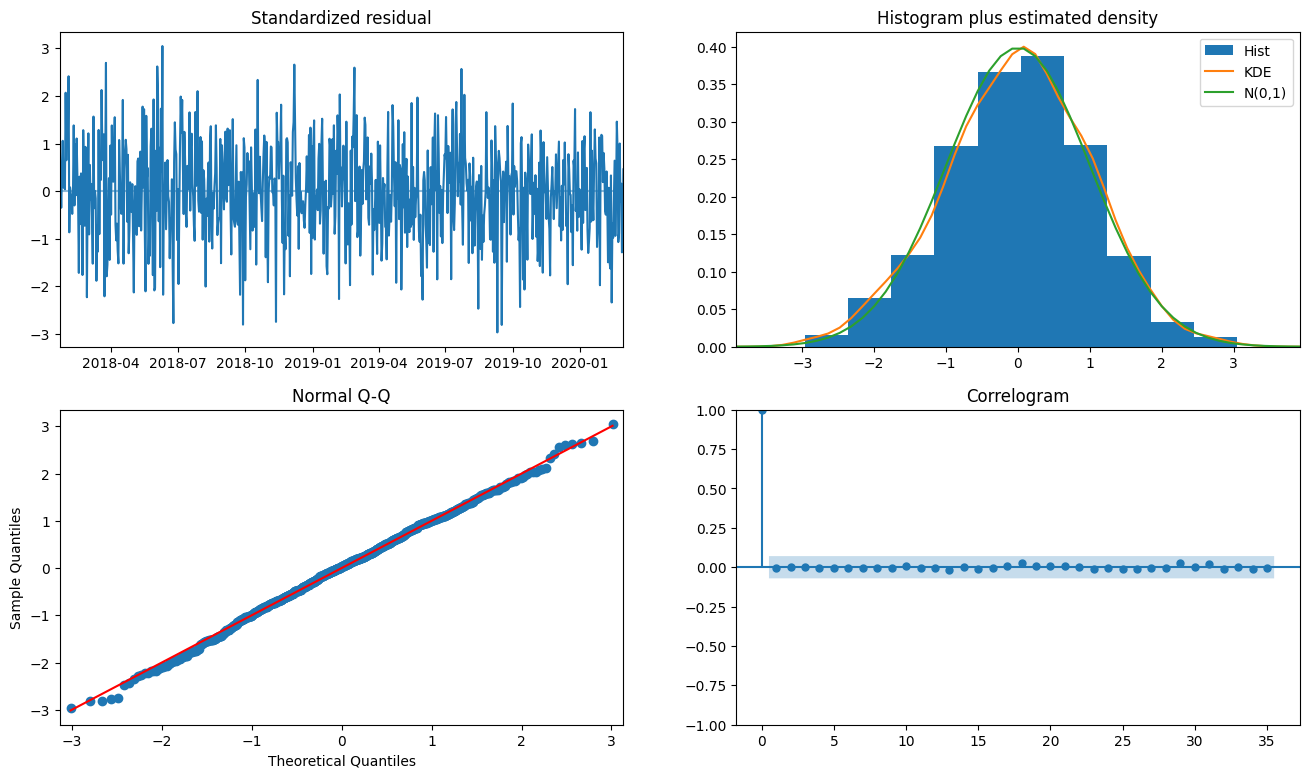

In [451]:
fig = pyplot.figure(figsize=(16, 9))
fig = res.plot_diagnostics(fig=fig, lags=35)

In [452]:
params = AutoReg(train, lags = 365)
res = params.fit()
res.aic, res.bic, res.hqic

(-1077.8647674652461, 597.5874765377316, -430.62880238921684)

In [453]:
# testing = pd.concat([train,test])
# ar35_predictions = []

# for i in range(len(train), len(train) + len(test)):
#     updated_res = res.apply(testing[:i])
#     ar35_predictions.append(updated_res.forecast(1).iloc[0])

# predictions = pd.DataFrame({
#     "AR": ar35_predictions,
#     "Actual": test['value'],
# })
# _, ax = pyplot.subplots()
# ax = predictions.plot(ax=ax)

# another try 
# testing = train.copy()
# ar35_predictions = []

# for i in range(len(train), len(train) + len(test)):
#     forecasted_value = updated_res.forecast(1).iloc[0]
#     ar35_predictions.append(forecasted_value)

#     next_date = testing.index[-1] + pd.Timedelta(days=1)
#     testing.loc[next_date] = forecasted_value

#     updated_res = res.apply(testing[:i])

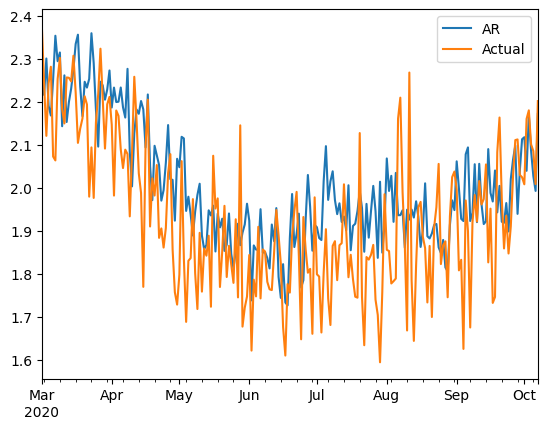

In [454]:
predictions = pd.DataFrame({
    "AR": res.forecast(len(test['value'])),
    "Actual": test['value'],
})
_, ax = pyplot.subplots()
ax = predictions.plot(ax=ax)

In [455]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-9))) * 100

In [456]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(predictions['AR'], test['value']))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.147


In [457]:
mape(predictions['AR'], test['value'])

5.909054811620302

inverse boxcox

In [458]:
boxcox_predictions = predictions['AR']

if lambda_value == 0:
    original_predictions = np.exp(boxcox_predictions)  # Use exponential if lambda = 0
else:
    original_predictions = np.power(lambda_value * boxcox_predictions + 1, 1 / lambda_value)

In [459]:
test_values = df_test.set_index("date_time")['value'].copy()
test_values.index = original_predictions.index

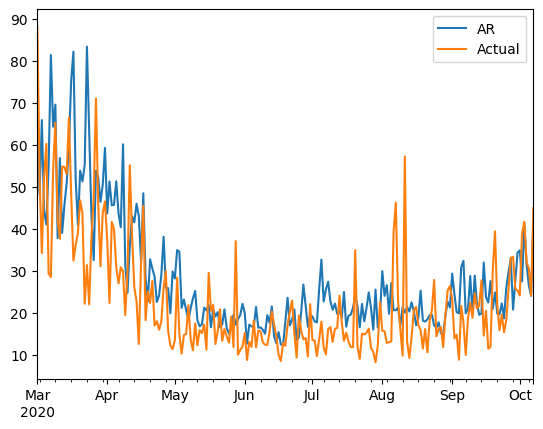

In [460]:
predictions = pd.DataFrame({
    "AR": original_predictions,
    "Actual": test_values,
})
_, ax = pyplot.subplots()
ax = predictions.plot(ax=ax)

In [461]:
a = original_predictions
b = test_values
mape(a, b), np.sqrt(mean_squared_error(a, b))

(30.48679997277163, 12.391407315099421)

In [462]:
def boxcox_to_orig(predictions, lambda_value):
    boxcox_predictions = predictions

    if lambda_value == 0:
        return np.exp(boxcox_predictions)  # Use exponential if lambda = 0
    else:
        return np.power(lambda_value * boxcox_predictions + 1, 1 / lambda_value)

In [463]:
t = df_train.set_index("date_time")
t.index = pd.to_datetime(t.index)

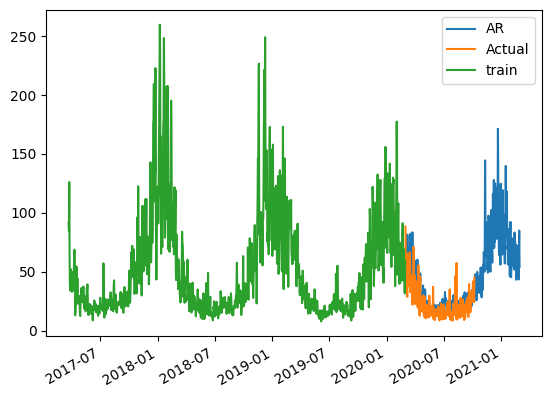

In [464]:
future_values = boxcox_to_orig(res.forecast(365*1), lambda_value)

predictions = pd.DataFrame({
    "AR": future_values,
    "Actual": test_values,
    "train": t['value']
})
_, ax = pyplot.subplots()
ax = predictions.plot(ax=ax)

## LSTM wth 1d Conv

In [49]:
import tensorflow as tf
from tensorflow import keras

np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",
                        input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train[:, 3::2], epochs=20,
                    validation_data=(X_valid, Y_valid[:, 3::2]))

## SARIMAX

In [ ]:
from itertools import product
import numpy as np

p = d = q = range(0, 3)
pdq = list(product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 7) for x in pdq]  # Weekly seasonality

best_aic = np.inf
best_params = None

for param in pdq:
    for seasonal_param in seasonal_pdq:
        try:
            model = SARIMAX(series, order=param, seasonal_order=seasonal_param).fit()
            if model.aic < best_aic:
                best_aic = model.aic
                best_params = (param, seasonal_param)
        except:
            continue

print(f"Best SARIMA Params: {best_params}")


In [ ]:
# from tbats import TBATS

# # Fit TBATS model
# estimator = TBATS(seasonal_periods=[7, 365])  # e.g., weekly and yearly
# model = estimator.fit(train)
# forecast = model.forecast(steps=30)


KeyboardInterrupt: 

In [433]:
(29.63913192734023, 9.08976815816162)
(29.564047932270327, 9.12509253676859) # 25

(29.564047932270327, 9.12509253676859)

In [182]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Align actual and predicted values for the OOT period
actual_oot = df_oot['value']
predicted_oot = average_prediction.loc[actual_oot.index]

# Calculate MAE
mae = mean_absolute_error(actual_oot, predicted_oot)

# Calculate MAPE (ensure no division by zero)
mape = (np.abs((actual_oot - predicted_oot) / actual_oot)).mean() * 100

# Calculate RMSE
rmse = mean_squared_error(actual_oot, predicted_oot, squared=False)

# Print results
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"RMSE: {rmse:.2f}")


MAE: 6.75
MAPE: 27.52%
RMSE: 10.09
